In [68]:
import numpy as np
import pandas as pd

import json

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

In [69]:
# Read the JSON file into Python
with open('blackout.json','r') as blackout:
    blackout_data = json.load(blackout)
    
# Convert the data into a dataframe
df = pd.DataFrame(blackout_data["data"])

In [259]:
### Set up the parameters
# Proportion of infected individuals that are symptomatic 
asym_ratio = 0.4

# Day at which blackout is introduced
t_blackout_on = 40
# Day at which blackout is lifted
t_blackout_off = 100

# Empty lists of different states individuals
S_vec = np.zeros(len(df)) # Susceptible
I_vec = np.zeros(len(df)) # Infected (Symptomatic + Asymptomatic)
Sym_vec = np.zeros(len(df)) # Symptomatic Individuals
Asym_vec = np.zeros(len(df)) # Asymptomatic indiviudals 
R_vec = np.zeros(len(df)) # Recovered
D_vec = np.zeros(len(df)) # Dead
H_vec = np.zeros(len(df)) # Hospitalized
C_vec = np.zeros(len(df)) # Hospitalized in ICU
NC_vec = np.zeros(len(df)) # Newly infected individuals

# Get the time vector
time_vec = np.arange(len(df))

# Get the vectors of states
for i in range(len(df)):
    S_vec[i] = np.sum(df['susceptible'][i])
    I_vec[i] = np.sum(df['infected'][i])
    Sym_vec[i] = (1-asym_ratio) * I_vec[i]
    Asym_vec[i] = asym_ratio * I_vec[i]
    R_vec[i] = np.sum(df['immune'][i])
    D_vec[i] = np.sum(df['dead'][i])
    H_vec[i] = np.sum(df['hospitalized'][i])
    C_vec[i] = np.sum(df['critical_care'][i])
    NC_vec[i] = np.sum(df['new_cases'][i])

In [264]:
### Linear increase in number of available Lung Ventilators
def get_num_of_ventilators(t_vec, t_start_adding_vents,
                           num_weeks_adding_vents, num_vent_init, num_vent_end):
    """
    Function computes the linear increase in the number of available ventilators.
    ------
    Inputs:
    - t_vec (np.array): Time vector in days
    - t_start_adding_vents (int): Day of the simulation at which we start adding ventilators
    - num_weeks_adding_vents (int): Number of weeks for which we are adding the ventilators
    - num_vent_init (int): Initial number of ventilators
    - num_vent_end (int): Final number of ventilators
    ------
    Outputs: 
    - num_vents(np.array): A vector of numbers of ventilators at each day.
    """

    
    # Time when we stop adding ventilators  (end of June)
    t_stop_adding_vents = (t_start_adding_vents + num_weeks_adding_vents * 7)

    # Ramp up of the ventilators 
    num_vents = num_vent_init*np.ones(len(t_vec))

    # Assume linear increase in the number of ventilators
    for ind in np.arange(t_start_adding_vents,t_stop_adding_vents):
        num_vents[ind] = num_vents[num] + (num_vent_end - num_vent_init)/(num_weeks_adding_vents * 7)*(ind - t_start_adding_vents)
        
    # Set the number of ventilators to be constant after the end of ramp
    max_vents = np.argmax(num_vents)
    num_vents[max_vents:] = num_vent_end
    num_vents = np.floor(num_vents)
    
    return num_vents


In [267]:
# Time when we start adding the ventilators (assumed since end of March)
t_start_adding_vents = 14 # days

# Number of weeks over which the number of ventilators increases
num_weeks_adding_vents = 12

# Initial number of the lung ventilators in Slovakia at present
num_vent_init = 500

# Number of ventilators at the end of June
num_vent_end = 800

num_vents = get_num_of_ventilators(time_vec, t_start_adding_vents, num_weeks_adding_vents, num_vent_init, num_vent_end)

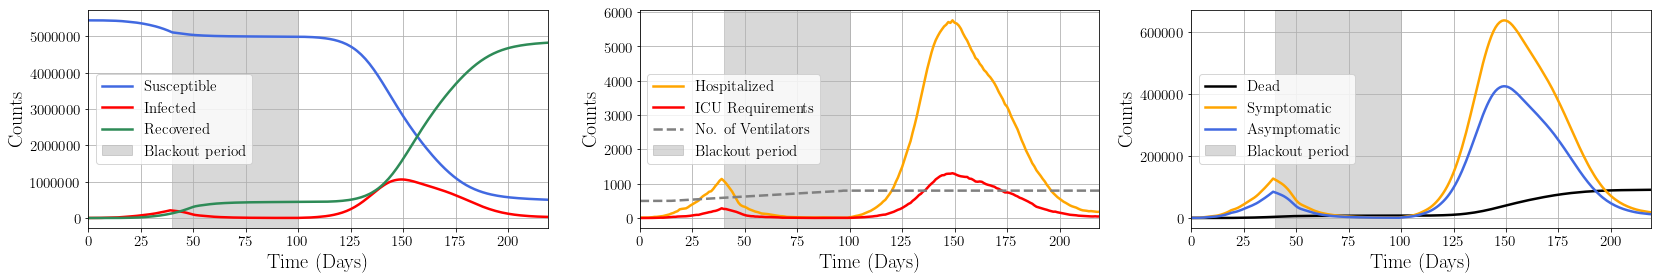

In [268]:
### Plotting

fig, axes = plt.subplots(1,3,figsize=(28,4))

# Plot the S, I, R states
# Plot the states
axes[0].plot(time_vec, S_vec, linewidth=2.5, label='Susceptible', color='royalblue')
axes[0].plot(time_vec, I_vec, linewidth=2.5, label='Infected', color='red')
axes[0].plot(time_vec, R_vec, linewidth=2.5, label='Recovered', color ='seagreen')

# Fill the portion of graph when blackout is on
axes[0].axvspan(t_blackout_on, t_blackout_off, alpha=0.3, label='Blackout period', color='grey')

# Set axis limits
axes[0].set_xlim(time_vec[0], time_vec[-1])
axes[0].grid()

# Set labels
axes[0].set_xlabel('Time (Days)', fontsize=20)
axes[0].set_ylabel('Counts', fontsize=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)

# Set the legend 
axes[0].legend(fontsize=15,loc='center left')

# Plot Hospitalzized and ICU states
# Plot the states
axes[1].plot(time_vec, H_vec, linewidth=2.5, label='Hospitalized', color='orange')
axes[1].plot(time_vec, C_vec, linewidth=2.5, label='ICU Requirements', color='red')
axes[1].plot(time_vec, num_vents, linestyle='--', linewidth=2.5, label='No. of Ventilators', color='grey')

# Fill the portion of graph when blackout is on
axes[1].axvspan(t_blackout_on, t_blackout_off, alpha=0.3, label='Blackout period', color='grey')

# Set axis limits
axes[1].set_xlim(time_vec[0], time_vec[-1])
axes[1].grid()

# Set axis labels
axes[1].set_xlabel('Time (Days)', fontsize=20)
axes[1].set_ylabel('Counts', fontsize=20)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)


# Set the legend 
axes[1].legend(fontsize=15,loc='center left')

# Plot Hospitalzized and ICU states
# Plot the states
axes[2].plot(time_vec, D_vec, linewidth=2.5, label='Dead', color='black')
axes[2].plot(time_vec, Sym_vec, linewidth=2.5, label='Symptomatic', color='orange')
axes[2].plot(time_vec, Asym_vec, linewidth=2.5, label='Asymptomatic', color='royalblue')

# Fill the portion of graph when blackout is on
axes[2].axvspan(t_blackout_on, t_blackout_off, alpha=0.3, label='Blackout period', color='grey')

# Set axis limits
axes[2].set_xlim(time_vec[0], time_vec[-1])
axes[2].grid()

# Set axis labels
axes[2].set_xlabel('Time (Days)', fontsize=20)
axes[2].set_ylabel('Counts', fontsize=20)
axes[2].tick_params(axis='x', labelsize=15)
axes[2].tick_params(axis='y', labelsize=15)

# Set the legend 
axes[2].legend(fontsize=15,loc='center left')